# CSC 529 Assignment 3
## Matt Triano

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import warnings
from IPython.display import display
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.feature_selection import SelectFromModel


%matplotlib inline

In [133]:
# Loading the data set and splitting off the target feature, 'Class'
image_df = pd.read_table("uspsdata.txt", header=None)
class_df = pd.read_table("uspscl.txt", header=None)
display(image_df.head(5))
display(class_df.head(5))

0    1     2      3      4      5       6       7       8       9    ...   \
0  0.0  0.0  0.00   0.00   0.95  11.91   49.02  106.96  152.14  157.77  ...    
1  0.0  0.0  3.31  19.03  51.45  87.66  106.14  102.35   96.37  106.66  ...    
2  0.0  0.0  0.02   1.86  12.63  42.03   84.17  104.87   79.06   32.90  ...    
3  0.0  0.0  0.00   0.01   5.93  33.21   75.00   85.97   51.36   14.25  ...    
4  0.0  0.0  0.94   8.57  32.06  63.96   74.10   50.12   18.39    2.83  ...    

      246     247     248     249     250     251    252    253    254   255  
0  145.84  154.03  152.60  142.38  125.40  100.57  69.80  38.67  14.58  2.80  
1  125.28  141.59  145.34  135.52  110.81   74.17  36.65  11.53   1.81  0.07  
2  158.29  150.08  134.27  113.54   85.57   52.14  23.76   7.75   1.76  0.23  
3  157.26  156.53  139.58  104.68   63.12   28.38   8.15   1.11   0.02  0.00  
4   93.12   87.66   59.11   26.47    8.72    2.48   0.42   0.00   0.00  0.00  

[5 rows x 256 columns]

0
0 -1
1 -1
2  1
3  1
4  1

In [134]:
scaler = StandardScaler()
scaled_image_df = scaler.fit_transform(image_df)

In [135]:
img_train, img_test, class_train, class_test = train_test_split(scaled_image_df,
                                                                class_df,
                                                                test_size=0.20,
                                                                random_state=123)

In [136]:
# switch to LinearSVC when making SVCs with datasets > 10k rows
# svm_clf = LinearSVC(C=1, loss="hinge")  
svm_clf = SVC(kernel='linear')

In [140]:
parameters = {
    'C': [1e-05, 2e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 
          1e-04, 2e-04, 3e-04, 4e-04, 5e-04, 
          1e-03, 2e-03, 5e-03, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5],
    'random_state': [123]
}

In [141]:
svm_clf_grid = GridSearchCV(svm_clf, parameters, verbose=4, cv=30, n_jobs=-1)

# As the GridSearchCV function inherently 
%time svm_clf_grid.fit(scaled_image_df, np.ravel(class_df))

Fitting 30 folds for each of 23 candidates, totalling 690 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s


Wall time: 4.84 s


[Parallel(n_jobs=-1)]: Done 690 out of 690 | elapsed:    4.3s finished


GridSearchCV(cv=30, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'random_state': [123], 'C': [1e-05, 2e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [151]:
def print_clf_grid_stats(grid_clf, gamma=False, wantPrint=True):
    print('C value that produces the most accurate model: {}'.format(grid_clf.best_params_))
    print('Score of the most accurate model: {:.6f} \n'.format(grid_clf.best_score_))
    means = grid_clf.cv_results_['mean_test_score']
    stdevs = grid_clf.cv_results_['std_test_score']
    c_list_ = []
    g_list_ = []
    if wantPrint:
        print('   --- Mean accuracy (+/- standard deviation) for different C values ---')
    for mean, stdev, param in zip(means, stdevs, grid_clf.cv_results_['params']):
        c_list_.append(param['C'])
        if gamma:
            g_list_.append(param['gamma'])
        if wantPrint:
            print('{:0.3f} (+/- {:0.3f}) for the model with parameters {}'
                  .format(mean, stdev, param))
    return means, stdevs, c_list_, g_list_

score_means, score_stdevs, c_list, _ = print_clf_grid_stats(svm_clf_grid)

C value that produces the most accurate model: {'random_state': 123, 'C': 0.001}
Score of the most accurate model: 0.970000 

   --- Mean accuracy (+/- standard deviation) for different C values ---
0.835 (+/- 0.136) for the model with parameters {'random_state': 123, 'C': 1e-05}
0.835 (+/- 0.136) for the model with parameters {'random_state': 123, 'C': 2e-05}
0.835 (+/- 0.136) for the model with parameters {'random_state': 123, 'C': 5e-05}
0.835 (+/- 0.136) for the model with parameters {'random_state': 123, 'C': 6e-05}
0.835 (+/- 0.136) for the model with parameters {'random_state': 123, 'C': 7e-05}
0.880 (+/- 0.113) for the model with parameters {'random_state': 123, 'C': 8e-05}
0.915 (+/- 0.086) for the model with parameters {'random_state': 123, 'C': 9e-05}
0.915 (+/- 0.086) for the model with parameters {'random_state': 123, 'C': 0.0001}
0.950 (+/- 0.069) for the model with parameters {'random_state': 123, 'C': 0.0002}
0.965 (+/- 0.061) for the model with parameters {'random_stat

In [138]:
# Apparently Seaborn's tsplot will be deprecated, so I made just made a similar
#  plot using matplotlib (Seaborn is just a nice wrapper for matplotlib anyway)
def errorbar_lineplot(ax, x, y, stdev, **kw):
    c_intervals = (y - stdev, y + stdev)
    ax.fill_between(x, c_intervals[0], c_intervals[1], alpha=0.2, **kw)
    ax.plot(x, y, **kw)

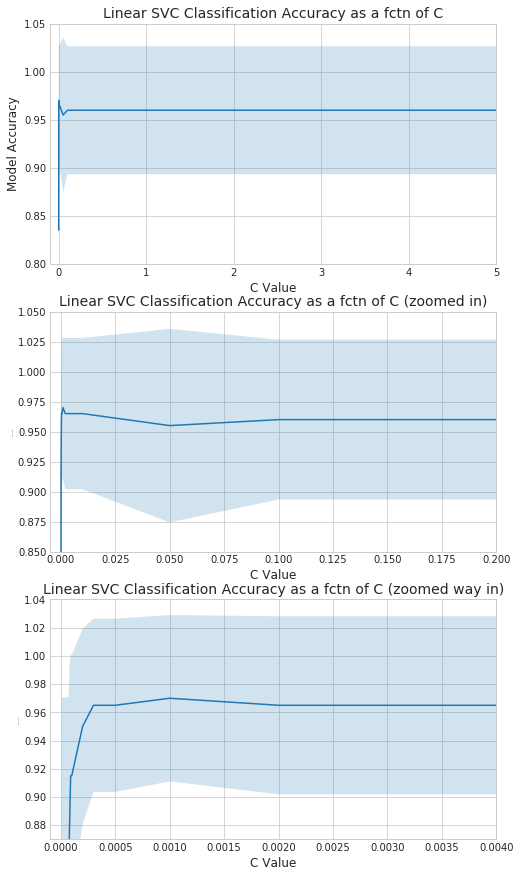

In [10]:
with plt.style.context('seaborn-whitegrid'):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=False, figsize=(8,15))
    errorbar_lineplot(ax1, c_list, score_means, score_stdevs)
    ax1.set_xlabel('C Value', fontsize=12)
    ax1.set_ylabel('Model Accuracy', fontsize=12)
    ax1.set_ylim([0.8,1.05])
    ax1.set_xlim([-0.1,5.0])
    ax1.set_title('Linear SVC Classification Accuracy as a fctn of C', fontsize=14)
    errorbar_lineplot(ax2, c_list, score_means, score_stdevs)
    ax2.set_xlabel('C Value', fontsize=12)
    ax2.set_ylabel('Model Accuracy', fontsize=1)
    ax2.set_ylim([0.85,1.05])
    ax2.set_xlim([-0.005,0.2])
    ax2.set_title('Linear SVC Classification Accuracy as a fctn of C (zoomed in)', fontsize=14)
    errorbar_lineplot(ax3, c_list, score_means, score_stdevs)
    ax3.set_xlabel('C Value', fontsize=12)
    ax3.set_ylabel('Model Accuracy', fontsize=1)
    ax3.set_ylim([0.87,1.04])
    ax3.set_xlim([-0.0001,0.004])
    ax3.set_title('Linear SVC Classification Accuracy as a fctn of C (zoomed way in)', fontsize=14)

## Analysis of linear SVM model with a varied soft margin

Looking at the printout of accuracy values and the plots of classifier accuracy as a function of C value, we see that model accuracy rises as C increases from $C = 0.00001$ to a peak accuracy at $C=0.001$ then a shallow dip and then model accuracy converges to a constant hyperplane (or at least a hyperplane that doesn't cross over any additional datapoints) for all values of $C >= 0.100$. This kind contradicts my intuition, as higher values of $C$ indicate a greater aversion to misclassification (ie inaccuracy). 

In [143]:
# This function calculates the total accuracy of a classifiers, clf 
#  on the same training and testing data, as well as the accuracy on the training
#  data (which gives the resubstitution (resub) error) and accuracy on the testing
#  data (which gives the generalization error).
# Takes 2 classifiers that conform to the sklearn classifier interface, strings
#  containing the names of the classifiers
# data_df:  an array-like object containing 
def svm_c_explorer(clf, clf_name, data_df, class_df,\
                   test_size=0.34, printStats=True, n_trials=30, seed=1234):
    rng = np.random.RandomState(seed)
    random_seeds = rng.randint(low=0, high=99999, size=n_trials)
    clf_acc = [] #; clf_resub_acc = []; clf_gen_acc = []
    for i in range(n_trials):
        data_train_, data_test_, class_train_, class_test_ = \
                train_test_split(data_df, class_df, test_size=test_size, \
                                 random_state=random_seeds[i])
        clf_acc.append(clf_evaluation(clf, data_train_, data_test_, class_train_, class_test_))
    mean_var_CI_calculator(clf_name, pd.Series(clf_acc), test_size, printStats)
    return clf_acc #, clf_resub_acc, clf_gen_acc

# This executes a simple fit-predict-evaluate routine with a single data split.
# classifier:   a classifier model that conforms to sklearns regular classifier interface
# data/class_train/test: array-like containers holding corresponding data and class labels
def clf_evaluation(clf_, data_train_, data_test_, class_train_, class_test_):
    clf_fit = clf_.fit(data_train_, class_train_)
    clf_pred = clf_.predict(data_test_)
    return accuracy_score(class_test_, clf_pred)

In [146]:
svm_clf = SVC()
params_gauss = {
    'kernel': ['rbf'],
    'gamma': [0.001, 0.002, 0.003, 0.004, 0.005, 0.007, 0.01, 0.1, 1],
    'C': [1e-05, 7e-05, 1e-04, 5e-04, 9e-04, 
          1e-03, 2e-03, 5e-03, 0.01, 0.05, 0.1, 
          0.125, 0.15, 0.175, 0.2, 0.25, 0.5, 1, 2, 5]    
}

In [147]:
svm_gauss_clf_grid = GridSearchCV(svm_clf, params_gauss, verbose=4, cv=30, n_jobs=-1)

%time svm_gauss_clf_grid.fit(scaled_image_df, np.ravel(class_df))

Fitting 30 folds for each of 180 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1325 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2209 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 3285 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 4677 tasks      | elapsed:   26.8s


Wall time: 29.9 s


[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed:   29.3s finished


GridSearchCV(cv=30, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gamma': [0.001, 0.002, 0.003, 0.004, 0.005, 0.007, 0.01, 0.1, 1], 'kernel': ['rbf'], 'C': [1e-05, 7e-05, 0.0001, 0.0005, 0.0009, 0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.5, 1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=4)

In [191]:
score_means, score_stdevs, c_list, g_list = print_clf_grid_stats(svm_gauss_clf_grid, True, False)

C value that produces the most accurate model: {'gamma': 0.003, 'kernel': 'rbf', 'C': 0.15}
Score of the most accurate model: 0.985000 



## Gaussian SVM

$$\gamma = \frac{1}{2\sigma^2} \text{  so by rearanging, we get   } \sigma = \sqrt{\frac{1}{2\gamma}}$$

In [169]:
gamma2sigma = lambda x: np.sqrt(1/(2*x))
sigmafier = np.vectorize(gamma2sigma)
sigma_list = sigmafier(g_list)

In [172]:
gauss_data = {'mean_acc': score_means,
              'mean_std': score_stdevs,
              'sigma':sigma_list,
              'C':c_list}
gauss_df = pd.DataFrame(gauss_data)
gauss_df = gauss_df.sort_values('sigma')
gauss_df_bestC = gauss_df[gauss_df['C']==0.15]
gauss_df_bestC
np.unique(c_list)

array([  1.00000000e-05,   7.00000000e-05,   1.00000000e-04,
         5.00000000e-04,   9.00000000e-04,   1.00000000e-03,
         2.00000000e-03,   5.00000000e-03,   1.00000000e-02,
         5.00000000e-02,   1.00000000e-01,   1.25000000e-01,
         1.50000000e-01,   1.75000000e-01,   2.00000000e-01,
         2.50000000e-01,   5.00000000e-01,   1.00000000e+00,
         2.00000000e+00,   5.00000000e+00])

In [184]:
def errorbar_lineplot(ax, x, y, stdev, **kw):
    c_intervals = (y - stdev, y + stdev)
    ax.fill_between(x, c_intervals[0], c_intervals[1], alpha=0.2, **kw)
    ax.plot(x, y, **kw)
    
type(df_00001['sigma'])

pandas.core.series.Series

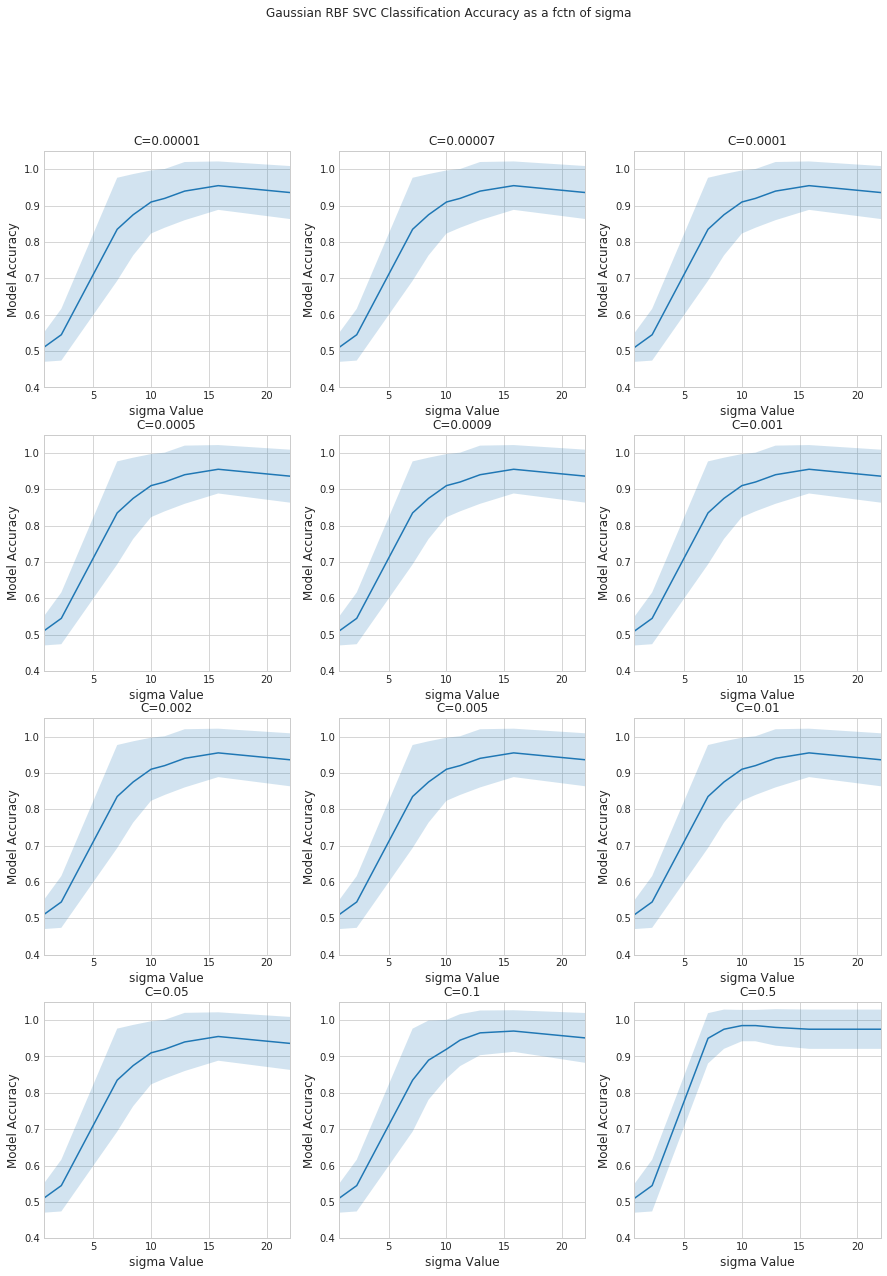

In [201]:
title = 'Gaussian RBF SVC Classification Accuracy as a fctn of sigma'
xlab = 'sigma Value'
df_00001 = gauss_df[gauss_df['C']==0.00001]
df_00007 = gauss_df[gauss_df['C']==0.00007]
df_0001 = gauss_df[gauss_df['C']==0.0001]
df_0005 = gauss_df[gauss_df['C']==0.0005]
df_0009 = gauss_df[gauss_df['C']==0.0009]
df_001 = gauss_df[gauss_df['C']==0.001]
df_002 = gauss_df[gauss_df['C']==0.002]
df_005 = gauss_df[gauss_df['C']==0.005]
df_01 = gauss_df[gauss_df['C']==0.01]
df_05 = gauss_df[gauss_df['C']==0.05]
df_1 = gauss_df[gauss_df['C']==0.1]
df_5 = gauss_df[gauss_df['C']==0.5]
with plt.style.context('seaborn-whitegrid'):
#     fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=3, sharey=False, sharex=False, figsize=(12,12))
    fig, ax = plt.subplots(nrows=4, ncols=3, sharey=False, sharex=False, figsize=(15,20))
    ax = ax.flatten()
    fig.suptitle(title)
    errorbar_lineplot(ax[0], df_00001['sigma'], df_00001['mean_acc'], df_00001['mean_std'])
    ax[0].set_xlabel(xlab, fontsize=12)
    ax[0].set_ylabel('Model Accuracy', fontsize=12)
    ax[0].set_ylim([0.4,1.05])
    ax[0].set_xlim([0.7,22])
    ax[0].set_title('C=0.00001')
    errorbar_lineplot(ax[1], df_00007['sigma'], df_00007['mean_acc'], df_00007['mean_std'])
    ax[1].set_xlabel(xlab, fontsize=12)
    ax[1].set_ylabel('Model Accuracy', fontsize=12)
    ax[1].set_ylim([0.4,1.05])
    ax[1].set_xlim([0.7,22])
    ax[1].set_title('C=0.00007')
    errorbar_lineplot(ax[2], df_0001['sigma'], df_0001['mean_acc'], df_0001['mean_std'])
    ax[2].set_xlabel(xlab, fontsize=12)
    ax[2].set_ylabel('Model Accuracy', fontsize=12)
    ax[2].set_ylim([0.4,1.05])
    ax[2].set_xlim([0.7,22])
    ax[2].set_title('C=0.0001')
    errorbar_lineplot(ax[3], df_0005['sigma'], df_0005['mean_acc'], df_0005['mean_std'])
    ax[3].set_xlabel(xlab, fontsize=12)
    ax[3].set_ylabel('Model Accuracy', fontsize=12)
    ax[3].set_ylim([0.4,1.05])
    ax[3].set_xlim([0.7,22])
    ax[3].set_title('C=0.0005')
    errorbar_lineplot(ax[4], df_0009['sigma'], df_0009['mean_acc'], df_0009['mean_std'])
    ax[4].set_xlabel(xlab, fontsize=12)
    ax[4].set_ylabel('Model Accuracy', fontsize=12)
    ax[4].set_ylim([0.4,1.05])
    ax[4].set_xlim([0.7,22])
    ax[4].set_title('C=0.0009')
    errorbar_lineplot(ax[5], df_001['sigma'], df_001['mean_acc'], df_001['mean_std'])
    ax[5].set_xlabel(xlab, fontsize=12)
    ax[5].set_ylabel('Model Accuracy', fontsize=12)
    ax[5].set_ylim([0.4,1.05])
    ax[5].set_xlim([0.7,22])
    ax[5].set_title('C=0.001')
    errorbar_lineplot(ax[6], df_002['sigma'], df_002['mean_acc'], df_002['mean_std'])
    ax[6].set_xlabel(xlab, fontsize=12)
    ax[6].set_ylabel('Model Accuracy', fontsize=12)
    ax[6].set_ylim([0.4,1.05])
    ax[6].set_xlim([0.7,22])
    ax[6].set_title('C=0.002')
    errorbar_lineplot(ax[7], df_005['sigma'], df_005['mean_acc'], df_005['mean_std'])
    ax[7].set_xlabel(xlab, fontsize=12)
    ax[7].set_ylabel('Model Accuracy', fontsize=12)
    ax[7].set_ylim([0.4,1.05])
    ax[7].set_xlim([0.7,22])
    ax[7].set_title('C=0.005')
    errorbar_lineplot(ax[8], df_01['sigma'], df_01['mean_acc'], df_01['mean_std'])
    ax[8].set_xlabel(xlab, fontsize=12)
    ax[8].set_ylabel('Model Accuracy', fontsize=12)
    ax[8].set_ylim([0.4,1.05])
    ax[8].set_xlim([0.7,22])
    ax[8].set_title('C=0.01')
    errorbar_lineplot(ax[9], df_05['sigma'], df_05['mean_acc'], df_05['mean_std'])
    ax[9].set_xlabel(xlab, fontsize=12)
    ax[9].set_ylabel('Model Accuracy', fontsize=12)
    ax[9].set_ylim([0.4,1.05])
    ax[9].set_xlim([0.7,22])
    ax[9].set_title('C=0.05')
    errorbar_lineplot(ax[10], df_1['sigma'], df_1['mean_acc'], df_1['mean_std'])
    ax[10].set_xlabel(xlab, fontsize=12)
    ax[10].set_ylabel('Model Accuracy', fontsize=12)
    ax[10].set_ylim([0.4,1.05])
    ax[10].set_xlim([0.7,22])
    ax[10].set_title('C=0.1')
    errorbar_lineplot(ax[11], df_5['sigma'], df_5['mean_acc'], df_5['mean_std'])
    ax[11].set_xlabel(xlab, fontsize=12)
    ax[11].set_ylabel('Model Accuracy', fontsize=12)
    ax[11].set_ylim([0.4,1.05])
    ax[11].set_xlim([0.7,22])
    ax[11].set_title('C=0.5')

pandas.core.frame.DataFrame

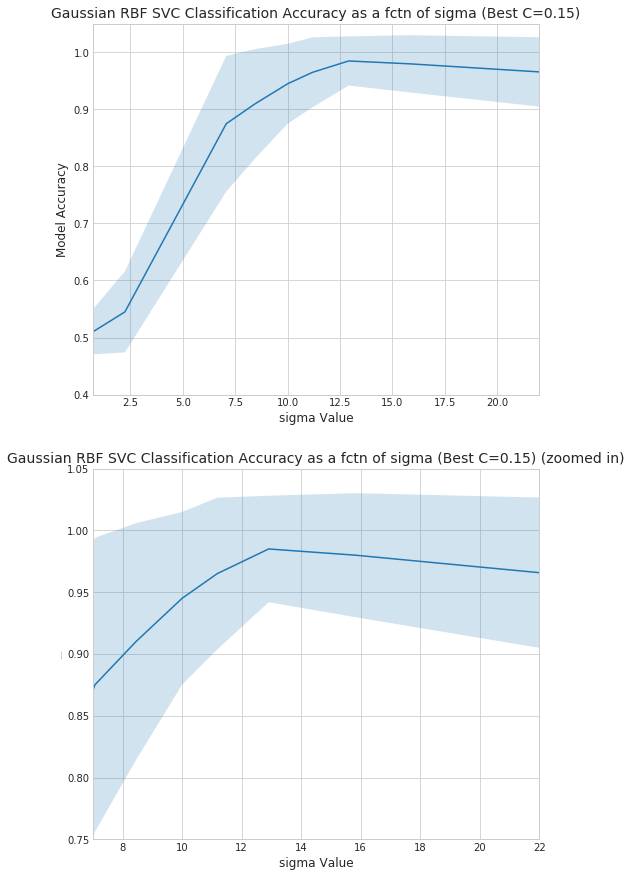

In [208]:
title = 'Gaussian RBF SVC Classification Accuracy as a fctn of sigma (Best C=0.15)'
xlab = 'sigma Value'
this_df = gauss_df[gauss_df['C']==0.15]  # C=0.15 produced the most accurate model
with plt.style.context('seaborn-whitegrid'):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=False, figsize=(8,15))
    errorbar_lineplot(ax1, this_df['sigma'], this_df['mean_acc'], this_df['mean_std'])
    ax1.set_xlabel(xlab, fontsize=12)
    ax1.set_ylabel('Model Accuracy', fontsize=12)
    ax1.set_ylim([0.4,1.05])
    ax1.set_xlim([0.7,22.0])
    ax1.set_title(title, fontsize=14)
    errorbar_lineplot(ax2, this_df['sigma'], this_df['mean_acc'], this_df['mean_std'])
    ax2.set_xlabel(xlab, fontsize=12)
    ax2.set_ylabel('Model Accuracy', fontsize=1)
    ax2.set_ylim([0.75,1.05])
    ax2.set_xlim([7,22])
    ax2.set_title(title + ' (zoomed in)', fontsize=14)

## 2: E-Commerce Customer Identification

In [6]:
train10k_raw = pd.read_csv('train10000.csv', header=None, na_values='999000.0')
train10k_labels = pd.read_csv('train10000_label.csv', header=None, na_values='999000.0')
test10k_raw = pd.read_csv('test10000.csv', header=None, na_values='998880.0')
test10k_labels = pd.read_csv('test10000_label.csv', header=None, na_values='999000.0')

# fixing column names
col_nums = np.arange(train10k_raw.shape[1])
X_gon_giveit2ya = np.vectorize(lambda x: 'x' + str(x))
train10k_raw.columns = X_gon_giveit2ya(col_nums)
train10k_labels.columns = ['Y']
test10k_raw.columns = X_gon_giveit2ya(col_nums)
test10k_labels.columns = ['Y']

In [7]:
print('Training Data')
display(train10k_raw.head(5))
print('Training Data DataFrame size = {}'.format(train10k_raw.shape))
print('***********************************************\n\nTesting Data')
display(test10k_raw.head(5))
print('Testing Data DataFrame size = {}'.format(test10k_raw.shape))
print('***********************************************\n\nTraining Labels')
display(train10k_labels.head(5))
print('Testing Labels')
display(test10k_labels.head(5))

Training Data


x0  x1   x2  x3        x4   x5   x6   x7   x8   x9  ...   x324  x325  \
0  NaN  46  2.0  46  196000.0  2.0  NaN  4.0  3.0  NaN  ...     59    19   
1  1.0  50  1.0  50  196000.0  1.0  4.0  7.0  5.0  1.0  ...     51    24   
2  NaN  50  1.0  50  196000.0  1.0  4.0  NaN  7.0  NaN  ...     61    20   
3  1.0  58  1.0  58  195000.0  2.0  4.0  NaN  8.0  2.0  ...     50    19   
4  NaN  64  1.0  64  196000.0  1.0  4.0  2.0  2.0  NaN  ...     57    23   

   x326  x327  x328  x329  x330  x331  x332  x333  
0    99    21     6     8    11    27   254   110  
1    89    13    11     2    10    30   169   144  
2    98    17     7     2    10    24   337   105  
3    83    12     8     4     4    31   280   165  
4    99    22     4     8    44    27   143    12  

[5 rows x 334 columns]

Training Data DataFrame size = (10000, 334)
***********************************************

Testing Data


x0  x1   x2  x3        x4   x5   x6  x7   x8   x9  ...   x324  x325  x326  \
0  1.0  36  3.0  36  197200.0  1.0  NaN NaN  7.0  2.0  ...     63     9    97   
1  0.0  36  1.0  38  196010.0  1.0  4.0 NaN  7.0  1.0  ...     53     7    81   
2  NaN  46  1.0  46  196010.0  1.0  4.0 NaN  7.0  NaN  ...     56    10    89   
3  1.0  42  1.0  42  196710.0  1.0  4.0 NaN  NaN  1.0  ...     63    13    84   
4  NaN  28  1.0  28  198010.0  2.0  NaN NaN  7.0  NaN  ...     53    12    88   

   x327  x328  x329  x330  x331  x332  x333  
0    24     3     4     7    14   347   111  
1    19     2     3     3     5   265   206  
2    22     4     3    12    13   418   143  
3     6     4    11     2    26   568   275  
4    18     4     5    21    19   328   227  

[5 rows x 334 columns]

Testing Data DataFrame size = (10000, 334)
***********************************************

Training Labels


Y
0  1
1  1
2  1
3  1
4  1

Testing Labels


Y
0  0
1  0
2  0
3  0
4  0

In [8]:
print('# of Observations in the Testing data with Label=1: {}'
      .format(len(test10k_labels[test10k_labels['Y'] == 1])))
print('# of Observations in the Training data with Label=1: {}'
      .format(len(train10k_labels[train10k_labels['Y'] == 1])))

# of Observations in the Testing data with Label=1: 939
# of Observations in the Training data with Label=1: 909


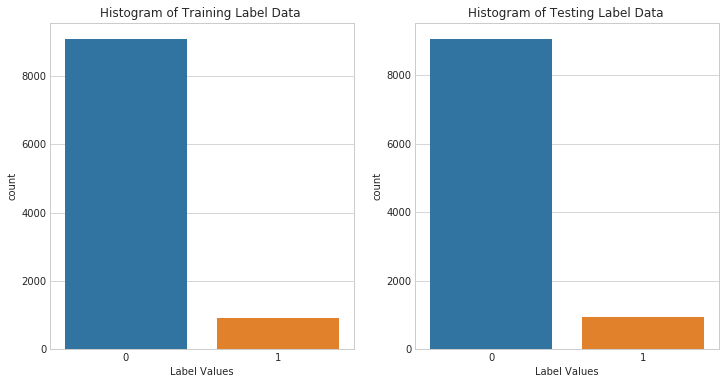

In [9]:
with plt.style.context('seaborn-whitegrid'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, figsize=(12,6))
    sns.countplot(train10k_labels['Y'], ax=ax1)
    sns.countplot(test10k_labels['Y'], ax=ax2)
    ax1.set_title('Histogram of Training Label Data ')
    ax2.set_title('Histogram of Testing Label Data ')
    ax1.set_xlabel('Label Values')
    ax2.set_xlabel('Label Values')

Looking at the distributions of labels, we see a fairly extreme imbalance in both the testing and training data. I'll build two classifiers to test whether it harms the classifier performance.

array([5211,    0, 2438,    0,    0, 2402, 4313, 7073, 3024, 5431,    0,
          0, 7704,    0, 5211,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  504,  504,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

array([5, 0, 5, ..., 3, 4, 9], dtype=int64)

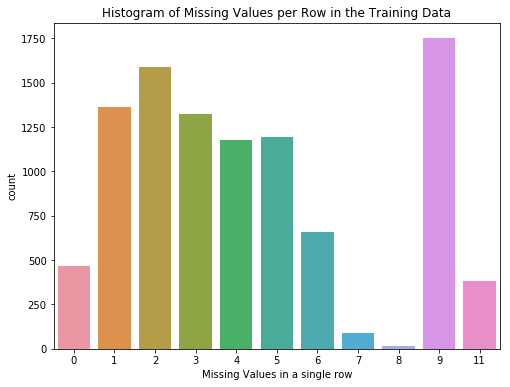

In [10]:
# Counts of missing values per column
train_NA_by_col = np.array(train10k_raw.isnull().sum(axis=0))
display(train_NA_by_col)

# Counts of missing values per row
train_NA_by_row = np.array(train10k_raw.isnull().sum(axis=1))
display(train_NA_by_row)

plt.figure(figsize=(8,6))
ax = sns.countplot(train_NA_by_row)
ax.set_title('Histogram of Missing Values per Row in the Training Data')
ax.set_xlabel('Missing Values in a single row')

array([5237,    0, 2378,    0,    0, 2288, 4212, 7102, 2906, 5413,    0,
          0, 7630,    0, 5237,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  528,  528,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

array([3, 2, 5, ..., 9, 1, 0], dtype=int64)

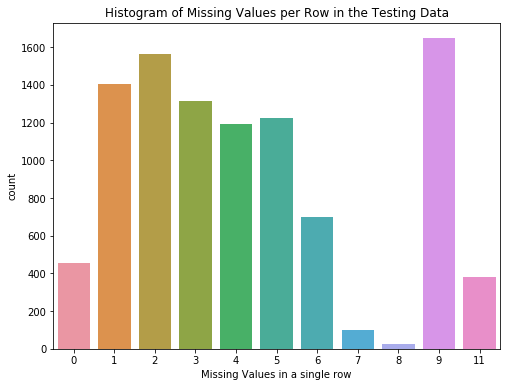

In [11]:
# Counts of missing values per column
test_NA_by_col = np.array(test10k_raw.isnull().sum(axis=0))
display(test_NA_by_col)

# Counts of missing values per row
test_NA_by_row = np.array(test10k_raw.isnull().sum(axis=1))
display(test_NA_by_row)

plt.figure(figsize=(8,6))
ax = sns.countplot(test_NA_by_row)
ax.set_title('Histogram of Missing Values per Row in the Testing Data')
ax.set_xlabel('Missing Values in a single row')

A small number of columns have many missing values (specifically 11 columns out of 334, or $3.3\%$). I don't know anything about how the data was collected or whether the missing values are missing because of systemic issues or whether they're missing completely at random. Still, as less than $3.5\%$ of the columns contain missing values (and some of those columns are missing as much as $77\%$! of their values), they are within standard rules of thumb for deletion (as stated in one of my CSC 424 texts: "Multivariate Data Analysis",m 7th ed. by Hair, Black, Babin, and Anderson). From inspection, we see the same columns in the training and testing data have missing values, so it's very easy to maintain the same columns in both the testing and training. Otherwise, I'd have to drop columns without missing values because of missing values in the complementary data.

In [12]:
test_cols_over_NA_thresh = train10k_raw.columns[test_NA_by_col >= 1]
test10k_trim = test10k_raw.drop(test_cols_over_NA_thresh, axis=1)
train10k_trim = train10k_raw.drop(test_cols_over_NA_thresh, axis=1)
print('\nTraining Data DataFrame after dropping the Columns that had ' + 
      ' missing values in the Testing Data')
display(train10k_trim.head(5))
print('\nTesting Data DataFrame after dropping the Columns that had ' + 
      ' missing values in the Testing Data')
display(test10k_trim.head(5))

train_cols_over_NA_thresh = train10k_raw.columns[train_NA_by_col >= 1]
# test10k_trim = test10k_trim.drop(train_cols_over_NA_thresh, axis=1)
# train10k_trim = train10k_trim.drop(train_cols_over_NA_thresh, axis=1)

print('\nTraining Data DataFrame after dropping the Columns that had ' + 
      ' missing values in the Testing Data')
# display(train10k_trim.head(5))
print('\nTesting Data DataFrame after dropping the Columns that had ' + 
      ' missing values in the Testing Data')
# display(test10k_trim.head(5))
display(train_cols_over_NA_thresh)
display(test_cols_over_NA_thresh)


Training Data DataFrame after dropping the Columns that had  missing values in the Testing Data


x1  x3        x4  x10  x11  x13  x15  x16  x17  x18  ...   x324  x325  \
0  46  46  196000.0   45    1   48   40  476  508  375  ...     59    19   
1  50  50  196000.0   35    4   46  170  504  533  421  ...     51    24   
2  50  50  196000.0   63    2   40  170  486  512  399  ...     61    20   
3  58  58  195000.0   80    2   36  170  470  505  390  ...     50    19   
4  64  64  196000.0   31    2    5   20  490  525  381  ...     57    23   

   x326  x327  x328  x329  x330  x331  x332  x333  
0    99    21     6     8    11    27   254   110  
1    89    13    11     2    10    30   169   144  
2    98    17     7     2    10    24   337   105  
3    83    12     8     4     4    31   280   165  
4    99    22     4     8    44    27   143    12  

[5 rows x 323 columns]


Testing Data DataFrame after dropping the Columns that had  missing values in the Testing Data


x1  x3        x4  x10  x11  x13  x15  x16  x17  x18  ...   x324  x325  \
0  36  36  197200.0   83    1   22  200  450  472  341  ...     63     9   
1  36  38  196010.0   60    3   21  220  416  441  314  ...     53     7   
2  46  46  196010.0   86    2   21  170  447  466  341  ...     56    10   
3  42  42  196710.0   99    1   57  170  433  450  400  ...     63    13   
4  28  28  198010.0  102    1   41  170  462  491  360  ...     53    12   

   x326  x327  x328  x329  x330  x331  x332  x333  
0    97    24     3     4     7    14   347   111  
1    81    19     2     3     3     5   265   206  
2    89    22     4     3    12    13   418   143  
3    84     6     4    11     2    26   568   275  
4    88    18     4     5    21    19   328   227  

[5 rows x 323 columns]


Training Data DataFrame after dropping the Columns that had  missing values in the Testing Data

Testing Data DataFrame after dropping the Columns that had  missing values in the Testing Data


Index(['x0', 'x2', 'x5', 'x6', 'x7', 'x8', 'x9', 'x12', 'x14', 'x27', 'x28'], dtype='object')

Index(['x0', 'x2', 'x5', 'x6', 'x7', 'x8', 'x9', 'x12', 'x14', 'x27', 'x28'], dtype='object')

In [13]:
parameters = {
    'criterion': ['entropy','gini'],
    'max_depth': [1,3],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,3,4],
    'random_state': [123]
}

dt_clf = tree.DecisionTreeClassifier()

dt_clf_gs = GridSearchCV(dt_clf, parameters, verbose=1, cv=30, n_jobs=-1)

In [13]:
train10k_trim.shape
c, r = train10k_labels.shape
np.array(train10k_labels).reshape(c, ).shape

(10000,)

In [32]:
%time _ = dt_clf_gs.fit(train10k_trim, np.array(train10k_labels).reshape(c, ))

dt_clf_gs.best_params_, dt_clf_gs.best_score_

Fitting 30 folds for each of 36 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.4min finished


Wall time: 1min 24s


({'criterion': 'gini',
  'max_depth': 3,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'random_state': 123},
 0.90920000000000001)

In [14]:
trim_dtree_clf = tree.DecisionTreeClassifier(criterion='entropy',
                                        max_depth = 1,
                                        min_samples_leaf = 1,
                                        min_samples_split = 2,
                                        random_state = 123)
trim_dtree_clf.fit(train10k_trim, train10k_labels)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [16]:
trim_dtree_preds = trim_dtree_clf.predict(test10k_trim)
trim_test_acc = accuracy_score(test10k_labels, trim_dtree_preds)
print('Classifier accuracy when trained with the imbalanced, NA-free training data: {:0.4f}'
      .format(trim_test_acc))

Classifier accuracy when trained with the imbalanced, NA-free training data: 0.9061


The decision tree built with this the NA-free, imbalanced training data had an accuracy of $90.61\%$. Not too shabby! We should probably check the confusion matrix though, just to confirm how awesome this model is. Although I am suspicious that the best decision tree classifier has a max depth of 1...

In [15]:
def confusion_mat_plotter(cfn_matrix, class_labels, title):
    print(cfn_matrix)
    sns.heatmap(cfn_matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('True Class')
    plt.ylabel('Predicted Class')
    plt.title('Confusion Matrix ' + title)

[[9061    0]
 [ 939    0]]


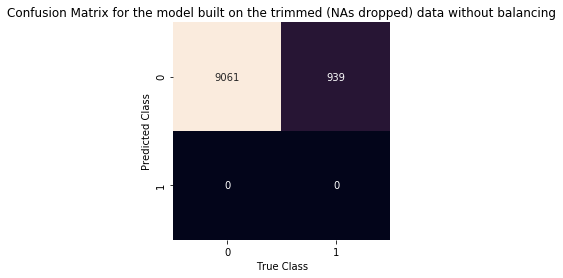

In [23]:
confusion_mat = metrics.confusion_matrix(test10k_labels, trim_dtree_preds)
confusion_mat_plotter(confusion_mat, [0,1], 
                      'for the model built on the trimmed (NAs dropped) data without balancing')

## Analysis of decision tree performance with only NA removal

Oh. Our classifier just a simple rule: everything is 0. Because the labels were so lopsided, it simply predicts that everything leads to the dominant label. ACCURACY PARADOX!

                                            Decision Tree Table
| Training Results | Sensitivity/precision | Specificity/Recall |
| :--------------: | --------------------: | :---------------- |
| Raw Data | $\frac{0}{939+0} = 0$ | $\frac{9061}{9061} = 1.0$ |
| Raw Data with Balanced Data |  |  |
| Normalize Attributes |  |  |
| Feature Selection |  |  |

In [39]:
parameters = {
    'criterion': ['entropy', 'gini'],
    'n_estimators': [30,50,100],
    'max_depth': [1,3,5],
    'max_features': [1,5,15],
    'min_samples_leaf': [1,3,5],
    'min_samples_split': [2,4,6]
}

rf_clf = RandomForestClassifier()

rf_clf_gs = GridSearchCV(rf_clf, parameters, verbose=4, cv=30, n_jobs=-1)

In [132]:
train10k_trim.shape
c, r = train10k_labels.shape
np.array(train10k_labels).reshape(c, )

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [43]:
%time _ = rf_clf_gs.fit(train10k_trim, np.array(train10k_labels).reshape(c, ))

rf_clf_gs.best_params_, rf_clf_gs.best_score_

Fitting 10 folds for each of 486 candidates, totalling 4860 fits


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:   26.4s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:   43.8s
[Parallel(n_jobs=4)]: Done 605 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 1193 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 1560 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=4)]: Done 2957 tasks      | elapsed:  8.4min
[Parallel(n_jobs=4)]: Done 3520 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done 4133 tasks      | elapsed: 11.5min
[Parallel(n_jobs=4)]: Done 4794 tasks      | elapsed: 13.9min
[Parallel(n_jobs=4)]: Done 4860 out of 4860 | elapsed: 14.2min finished


Wall time: 14min 14s


({'criterion': 'gini',
  'max_depth': 5,
  'max_features': 15,
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 50},
 0.90920000000000001)

In [40]:
trim_rf_clf = RandomForestClassifier(criterion='gini', max_depth=5, 
                                      max_features=15, min_samples_leaf=1,
                                      min_samples_split=6, n_estimators=50)
trim_rf_clf = trim_rf_clf.fit(train10k_trim, train10k_labels)
trim_rf_cv = cross_val_score(trim_rf_clf, train10k_trim,
                             np.array(train10k_labels).reshape(c, ),
                             cv=30,n_jobs=-1, verbose=1)

C:\Users\mattt\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.6s finished


Total Classification Accuracy: 0.909 +/- 0.0015)
[[9060    1]
 [ 939    0]]


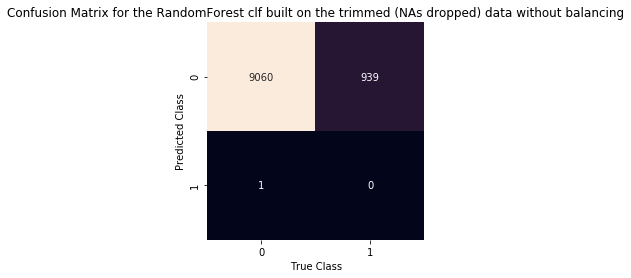

In [41]:
print("Total Classification Accuracy: {:0.3f} +/- {:0.4f})"
      .format(trim_rf_cv.mean(), trim_rf_cv.std()))
trim_rf_preds = trim_rf_clf.predict(test10k_trim)
confusion_mat = metrics.confusion_matrix(test10k_labels, trim_rf_preds)
confusion_mat_plotter(confusion_mat, [0,1], 
                      'for the RandomForest clf built on the trimmed'
                      +' (NAs dropped) data without balancing')

## Analysis of random forest performance with only NA removal

The Random Forest classifier that I spent so much time getting hyperparameters for produces the same accuracy, but it does predict at least (well, exactly) 1 positive label.

                                        Random Forest Table
| Training Results | Sensitivity/precision | Specificity/Recall |
| :--------------: | --------------------: | :---------------- |
| Raw Data | $\frac{0}{939+0} = 0$ | $\frac{9060}{9060+1} = 0.99989$ |
| Raw Data with Balanced Data |  |  |
| Normalize Attributes |  |  |
| Feature Selection |  |  |

In [16]:
# from imblearn.over_sampling import SMOTE, ADASYN
sm = SMOTE(kind='regular')
c, r = train10k_labels.shape
train10k_smote, train10k_labels_smote = sm.fit_sample(
                                train10k_trim, np.array(train10k_labels).reshape(c, ))
test10k_smote, test10k_labels_smote = sm.fit_sample(
                                test10k_trim, np.array(test10k_labels).reshape(c, ))

In [42]:
parameters = {
    'criterion': ['entropy','gini'],
    'max_depth': [15,25,35],
    'min_samples_leaf': [1,4,6],
    'min_samples_split': [2,4],
    'random_state': [123]
}

dt_clf = tree.DecisionTreeClassifier()

dt_clf_gs = GridSearchCV(dt_clf, parameters, verbose=1, cv=5, n_jobs=-1)

In [41]:
train10k_smote.shape
c_sm = train10k_labels_smote.shape

%time _ = dt_clf_gs.fit(train10k_smote, np.array(train10k_labels_smote).reshape(c_sm, ))

dt_clf_gs.best_params_, dt_clf_gs.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.1min finished


Wall time: 2min 12s


({'criterion': 'gini',
  'max_depth': 35,
  'min_samples_leaf': 4,
  'min_samples_split': 2,
  'random_state': 123},
 0.88752612473875259)

In [128]:
dtree_smote = tree.DecisionTreeClassifier(criterion='gini', max_depth=25,
                                          min_samples_leaf=4, min_samples_split=2,
                                          random_state=123)
dtree_smote = dtree_smote.fit(train10k_smote, train10k_labels_smote)
dtree_smote_cv = cross_val_score(dtree_smote, train10k_smote,
                                 train10k_labels_smote,
                                 cv=30,n_jobs=-1, verbose=4)

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   21.4s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   26.1s finished


Total Classification Accuracy: 0.897 +/- 0.1049)
[[8265  796]
 [2250 6811]]


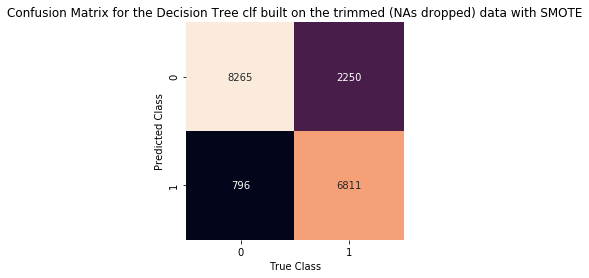

In [129]:
print("Total Classification Accuracy: {:0.3f} +/- {:0.4f})"
      .format(dtree_smote_cv.mean(), dtree_smote_cv.std()))
dtree_smote_preds = dtree_smote.predict(test10k_smote)
confusion_mat = metrics.confusion_matrix(test10k_labels_smote, dtree_smote_preds)
confusion_mat_plotter(confusion_mat, [0,1], 
                      'for the Decision Tree clf built on the trimmed'
                      +' (NAs dropped) data with SMOTE')

## Analysis of decision tree performance with SMOTE

This decision tree classifier built on the balanced (via SMOTE) training and testing data isn't quite as accurate as the earlier classifier that predicted everything had the same label, but this classifier has far more sensitivity and comparable specificity. 

                                            Decision Tree Table
|--- Training Results ---|--- Sensitivity/precision ---|---- Specificity/Recall ---|
| :--------------: | --------------------: | :---------------- |
| Raw Data | $\frac{0}{939 + 0} = 0$ | $\frac{9061}{10000} = 0.9061$ |
| Raw Data with Balanced Data | $\frac{7155}{7155+1906} = 0.7897$ | $\frac{8154}{8154+907} = 0.8999$ |
| Normalize Attributes |  |  |
| Feature Selection |  |  |

In [54]:
parameters = {
    'criterion': ['entropy'],
    'n_estimators': [75,100],
    'max_depth': [10,20],
    'max_features': [15,25],
    'min_samples_leaf': [1,3,5],
    'min_samples_split': [2,4,6]
}

rf_clf = RandomForestClassifier()

rf_clf_gs = GridSearchCV(rf_clf, parameters, verbose=4, cv=3, n_jobs=-1)

In [55]:
%time _ = rf_clf_gs.fit(train10k_smote, train10k_labels_smote)

rf_clf_gs.best_params_, rf_clf_gs.best_score_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  9.8min finished


Wall time: 10min 10s


({'criterion': 'entropy',
  'max_depth': 20,
  'max_features': 25,
  'min_samples_leaf': 5,
  'min_samples_split': 4,
  'n_estimators': 75},
 0.93625563744362561)

In [130]:
rf_smote = RandomForestClassifier(criterion='entropy', max_depth=20,
                                  max_features=25, min_samples_leaf=5,
                                  min_samples_split=4, n_estimators=75)
rf_smote = rf_smote.fit(train10k_smote, train10k_labels_smote)
rf_smote_cv = cross_val_score(rf_smote, train10k_smote,
                             train10k_labels_smote,
                             cv=30,n_jobs=-1, verbose=4)

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.5min finished


Total Classification Accuracy: 0.9408 +/- 0.1266)
[[8883  178]
 [1643 7418]]


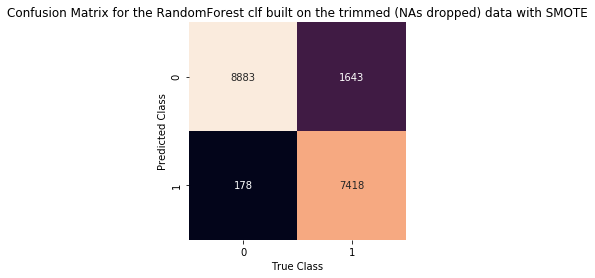

In [131]:
print("Total Classification Accuracy: {:0.4f} +/- {:0.4f})"
      .format(rf_smote_cv.mean(), rf_smote_cv.std()))
rf_smote_preds = rf_smote.predict(test10k_smote)
confusion_mat = metrics.confusion_matrix(test10k_labels_smote, rf_smote_preds)
confusion_mat_plotter(confusion_mat, [0,1], 
                      'for the RandomForest clf built on the trimmed'
                      +' (NAs dropped) data with SMOTE')

## Analysis of random forest performance with SMOTE

By using the training data balanced by SMOTE and a random forest classifier, we achieved a model that is more accurate than the simple dumb model and has a vastly improved sensitivity. Now I'll investigate what impact, if any, normalization has on the accuracy, sensitivity, or specificity of our classifiers. I expect normalization won't have any significant impact on our classifiers as they're both based on decision trees, which don't depend on a distance metric. 

                                        Random Forest Table
|--- Training Results ---|--- Sensitivity/precision ---|---- Specificity/Recall ---|
| :--------------: | --------------------: | :---------------- |
| Raw Data | $\frac{0}{939+0} = 0$ | $\frac{9060}{9060+1} = 0.99989$ |
| Raw Data with Balanced Data | $\frac{7363}{7363+1698} = 0.81260$ | $\frac{8866}{8866+195} = 0.97848$ |
| Normalize Attributes |  |  |
| Feature Selection |  |  |

In [17]:
scaler = StandardScaler()
train10k_scaled = scaler.fit_transform(train10k_smote)
test10k_scaled = scaler.fit_transform(test10k_smote)

In [37]:
parameters = {
    'criterion': ['entropy','gini'],
    'max_depth': [25,35,45],
    'min_samples_leaf': [1,4],
    'min_samples_split': [2,4,6],
    'random_state': [123]
}

dt_clf = tree.DecisionTreeClassifier()

dt_clf_gs = GridSearchCV(dt_clf, parameters, verbose=4, cv=3, n_jobs=-1)

In [38]:
train10k_smote.shape
c_sm = train10k_labels_smote.shape
%time _ = dt_clf_gs.fit(train10k_scaled, train10k_labels_smote)

dt_clf_gs.best_params_, dt_clf_gs.best_score_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.1min finished


Wall time: 1min 10s


({'criterion': 'entropy',
  'max_depth': 35,
  'min_samples_leaf': 1,
  'min_samples_split': 4,
  'random_state': 123},
 0.88598614013859867)

In [48]:
dtree_scaled = tree.DecisionTreeClassifier(criterion='entropy', max_depth=35,
                                          min_samples_leaf=1, min_samples_split=4,
                                          random_state=123)
dtree_scaled = dtree_scaled.fit(train10k_scaled, train10k_labels_smote)
dtree_scaled_cv = cross_val_score(dtree_scaled, train10k_scaled,
                                 train10k_labels_smote,
                                 cv=30,n_jobs=-1, verbose=4)

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   25.3s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   31.0s finished


Total Classification Accuracy: 0.891 +/- 0.1072)
[[  88 8973]
 [  57 9004]]


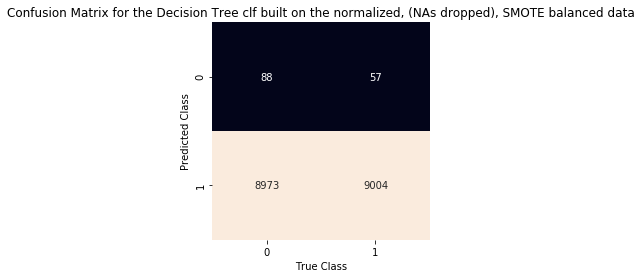

In [54]:
print("Total Classification Accuracy: {:0.3f} +/- {:0.4f})"
      .format(dtree_scaled_cv.mean(), dtree_scaled_cv.std()))
dtree_scaled_preds = dtree_scaled.predict(test10k_scaled)
confusion_mat = metrics.confusion_matrix(test10k_labels_smote, dtree_scaled_preds)
confusion_mat_plotter(confusion_mat, [0,1], 
                      'for the Decision Tree clf built on the normalized,'
                      +' (NAs dropped), SMOTE balanced data')

## Analysis of decision tree performance with normalized data

We actually see that normalization lead to a very slight decrease in accuracy compared with the unnormalized, SMOTE'd decision tree classifier, but the major change is in the specificity, which dropped from nearly $90\%$ down to just under $1\%$.  

                                            Decision Tree Table
|--- Training Results ---|--- Sensitivity/precision ---|---- Specificity/Recall ---|
| :--------------: | --------------------: | :---------------- |
| Raw Data | $\frac{0}{939 + 0} = 0$ | $\frac{9061}{10000} = 0.9061$ |
| Raw Data with Balanced Data | $\frac{7155}{7155+1906} = 0.7897$ | $\frac{8154}{8154+907} = 0.8999$ |
| Normalize Attributes | $\frac{9004}{9004+57} = 0.99371$ | $\frac{88}{8973+88} = 0.00971$ |
| Feature Selection |  |  |

In [53]:
rf_scaled = RandomForestClassifier(criterion='entropy', max_depth=20,
                                  max_features=25, min_samples_leaf=5,
                                  min_samples_split=4, n_estimators=75)
rf_scaled = rf_scaled.fit(train10k_scaled, train10k_labels_smote)
rf_scaled_cv = cross_val_score(rf_scaled, train10k_scaled,
                             train10k_labels_smote,
                             cv=30,n_jobs=-1, verbose=4)

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.8min remaining:   33.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished


Total Classification Accuracy: 0.9405 +/- 0.1253)
[[ 221 8840]
 [ 588 8473]]


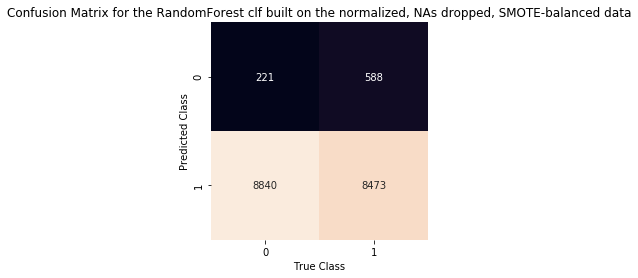

In [55]:
print("Total Classification Accuracy: {:0.4f} +/- {:0.4f})"
      .format(rf_scaled_cv.mean(), rf_scaled_cv.std()))
rf_scaled_preds = rf_scaled.predict(test10k_smote)
confusion_mat = metrics.confusion_matrix(test10k_labels_smote, rf_scaled_preds)
confusion_mat_plotter(confusion_mat, [0,1], 
                      'for the RandomForest clf built on the normalized,'
                      +' NAs dropped, SMOTE-balanced data')

## Analysis of random forest performance with normalized data

We see a similar effect with the random forest classifier (I didn't spend time adjusting hyperparameters this time). Comparable accuracy, severly harmed specificity. I had expected normalization to simply have no positive benefit for these decision tree based classifiers, but apparently by normalizing the data, it made it much harder for the classifiers to detect the class divisions in the data.  

                                        Random Forest Table
|--- Training Results ---|--- Sensitivity/precision ---|---- Specificity/Recall ---|
| :--------------: | --------------------: | :---------------- |
| Raw Data | $\frac{0}{939+0} = 0$ | $\frac{9060}{9060+1} = 0.99989$ |
| Raw Data with Balanced Data | $\frac{7363}{7363+1698} = 0.81260$ | $\frac{8866}{8866+195} = 0.97848$ |
| Normalize Attributes | $\frac{8473}{8473+588} = 0.06489$ | $\frac{8840}{8840+221} = 0.97561$ |
| Feature Selection |  |  |

## Feature Selection

Next, I'll explore the impact feature selection has on classifier performance. I'll continue using the SMOTE balanced data as that clearly had a significant positive impact on classifier performance.

In [19]:
dtree_smote = tree.DecisionTreeClassifier(criterion='gini', max_depth=25,
                                          min_samples_leaf=4, min_samples_split=2,
                                          random_state=123)
dtree_smote = dtree_smote.fit(train10k_smote, train10k_labels_smote)
dtree_smote_cv = cross_val_score(dtree_smote, train10k_smote,
                                 train10k_labels_smote,
                                 cv=30,n_jobs=-1, verbose=5)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:   19.6s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   24.4s finished


In [44]:
def feature_importance_zipper(model, feat_names, thresh=0.005):
    n = 0
    importances_ = [['feature', 'importance']]
    for feat in zip(feat_names, model.feature_importances_):
        importances_.append([feat[0], feat[1]])
        if feat[1] >= thresh:
            n += 1
    importances_df = pd.DataFrame(importances_)
    header = importances_df.iloc[0]
    importances_df = importances_df[1:]
    importances_df.rename(columns=header, inplace=True)
    return importances_df.sort_values(ascending=False, by='importance').head(n)

dtree_imp_feats = feature_importance_zipper(dtree_smote, train10k_trim.columns, 0.00003)
# display(dtree_imp_feats)

**Implementation Note**: In sklearn's implementation, the feature importances are calculated by randomly permuteing values for features and then measuring the decrease in accuracy on out-of-bag samples. After calculating importances for all features in a data set, the importances are normalized so that they sum to $1.00$.

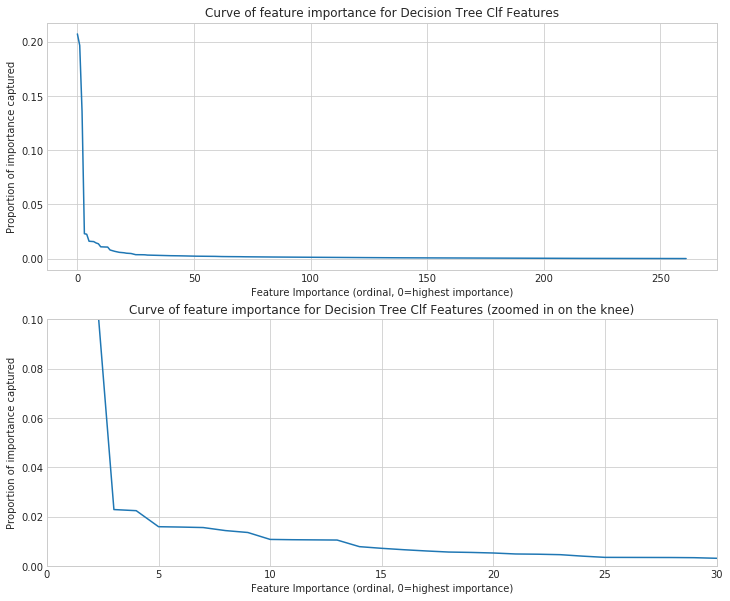

In [50]:
with plt.style.context('seaborn-whitegrid'):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=False, figsize=(12,10))
    ax1.plot(dtree_imp_feats['importance'].reset_index(drop=True))
    ax1.set_title('Curve of feature importance for Decision Tree Clf Features')
    ax1.set_xlabel('Feature Importance (ordinal, 0=highest importance)')
    ax1.set_ylabel('Proportion of importance captured')
    ax2.plot(dtree_imp_feats['importance'].reset_index(drop=True))
    ax2.set_title('Curve of feature importance for Decision Tree Clf'
                  +' Features (zoomed in on the knee)')
    ax2.set_xlabel('Feature Importance (ordinal, 0=highest importance)')
    ax2.set_ylabel('Proportion of importance captured')
    ax2.set_xlim([0,30])
    ax2.set_ylim([0,0.1])

In [48]:
print('The first {} features capture {:0.3f}% of the "importance".'
      .format(5, sum(dtree_imp_feats['importance'][0:5])*100))
print('The first {} features capture {:0.3f}% of the "importance".'
      .format(10, sum(dtree_imp_feats['importance'][0:10])*100))
print('The first {} features capture {:0.3f}% of the "importance".'
      .format(15, sum(dtree_imp_feats['importance'][0:15])*100))
print('The first {} features capture {:0.3f}% of the "importance".'
      .format(20, sum(dtree_imp_feats['importance'][0:20])*100))

The first 5 features capture 58.559% of the "importance".
The first 10 features capture 66.131% of the "importance".
The first 15 features capture 71.222% of the "importance".
The first 20 features capture 74.378% of the "importance".


From these plots, we see the knee in the importance plot is around 5, so I'll use the 5 best try to build a classifier with the 5 best features. 

In [72]:
def select_top_feats(df_, imp_feats_, top_n=5):
    top_feats = imp_feats_.head(top_n)
    top_inds = [int(s.replace('x','')) for s in top_feats.feature.values]
    return df_.take(top_inds, axis=1)

train10k_top5 = select_top_feats(train10k_smote, dtree_imp_feats)
test10k_top5 = select_top_feats(test10k_smote, dtree_imp_feats)

In [81]:
parameters = {
    'criterion': ['entropy','gini'],
    'max_depth': [15,25,30,35,40,45,55],
    'min_samples_leaf': [1,4,6],
    'min_samples_split': [2,4],
    'random_state': [123]
}

dt_clf = tree.DecisionTreeClassifier()

dt_clf_gs = GridSearchCV(dt_clf, parameters, verbose=4, cv=30, n_jobs=-1)

In [82]:
# c_sm = train10k_labels_smote.shape
%time _ = dt_clf_gs.fit(train10k_top5, train10k_labels_smote)

dt_clf_gs.best_params_, dt_clf_gs.best_score_

Fitting 30 folds for each of 84 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:   51.7s finished


Wall time: 52.4 s


({'criterion': 'entropy',
  'max_depth': 45,
  'min_samples_leaf': 4,
  'min_samples_split': 2,
  'random_state': 123},
 0.89819601803981963)

In [83]:
dtree_top5 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=45,
                                         min_samples_leaf=4, min_samples_split=2,
                                         random_state=123)
dtree_top5 = dtree_top5.fit(train10k_top5, train10k_labels_smote)
dtree_top5_cv = cross_val_score(dtree_top5, train10k_top5,
                                 train10k_labels_smote,
                                 cv=30,n_jobs=-1, verbose=4)

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    2.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.6s finished


Total Classification Accuracy: 0.8982 +/- 0.1252)
[[8493  568]
 [1893 7168]]


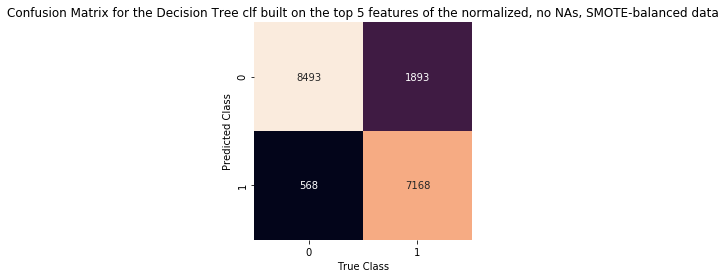

In [84]:
print("Total Classification Accuracy: {:0.4f} +/- {:0.4f})"
      .format(dtree_top5_cv.mean(), dtree_top5_cv.std()))
dtree_top5_preds = dtree_top5.predict(test10k_top5)
confusion_mat = metrics.confusion_matrix(test10k_labels_smote, dtree_top5_preds)
confusion_mat_plotter(confusion_mat, [0,1], 
                      'for the Decision Tree clf built on the top 5 features of' 
                      + ' the normalized, no NAs, SMOTE-balanced data')

## Analysis of decision tree performance with SMOTE and feature selection
This combination of preprocessing steps produced the best decision tree classifier yet. Compared with the classifier built on the (SMOTE and NA-drop)-only dataset, this classifier has both better sensitivity and better specificity, indicating that the many unimportant features added variance without benefit, and by trimming them, there was less noise obscuring the actual divisions between classes. Compared with the 'Normalized' classifier, this classifier doesn't have as high a score in sensitivity, but that's because that classifier was nearly as lopsided as the 'Raw' classifier, causing this classifier to have a massivly better specificity.

Another benefit of performing feature selection on the dataset is that GridSearch took way less time!

                                           Decision Tree Table
|--- Training Results ---|--- Sensitivity/precision ---|---- Specificity/Recall ---|
| :--------------: | --------------------: | :---------------- |
| Raw Data | $\frac{0}{939+0} = 0$ | $\frac{9061}{10000} = 0.9061$ |
| Raw Data with Balanced Data | $\frac{7155}{7155+1906} = 0.7897$ | $\frac{8154}{8154+907} = 0.8999$ |
| Normalize Attributes | $\frac{9004}{9004+57} = 0.99371$ | $\frac{88}{8973+88} = 0.00971$ |
| Feature Selection + SMOTE | $\frac{7168}{7168+1893} = 0.79108$ | $\frac{8493}{8493+568}=0.93731$ |

In [118]:
parameters = {
    'criterion': ['entropy'],
    'n_estimators': [50,75],
    'max_depth': [40,50,75],
    'max_features': [5],
    'min_samples_leaf': [3,5],
    'min_samples_split': [4,6]
}

rf_clf = RandomForestClassifier()

rf_clf_gs = GridSearchCV(rf_clf, parameters, verbose=4, cv=3, n_jobs=-1)

In [119]:
display(train10k_top5.shape)
display(train10k_smote.shape)

(18182, 5)

(18182, 323)

In [120]:
%time _ = rf_clf_gs.fit(train10k_top5, train10k_labels_smote)

rf_clf_gs.best_params_, rf_clf_gs.best_score_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   41.7s finished


Wall time: 47.1 s


({'criterion': 'entropy',
  'max_depth': 40,
  'max_features': 5,
  'min_samples_leaf': 3,
  'min_samples_split': 4,
  'n_estimators': 75},
 0.91964580354196457)

In [122]:
rf_top5 = RandomForestClassifier(criterion='entropy', max_depth=40,
                                  max_features=5, min_samples_leaf=3,
                                  min_samples_split=4, n_estimators=75)
rf_top5 = rf_top5.fit(train10k_top5, train10k_labels_smote)
rf_top5_cv = cross_val_score(rf_top5, train10k_smote,
                             train10k_labels_smote,
                             cv=30,n_jobs=-1, verbose=5)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:   32.9s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   41.0s finished


Total Classification Accuracy: 0.9368 +/- 0.1108)
[[8929  132]
 [1963 7098]]


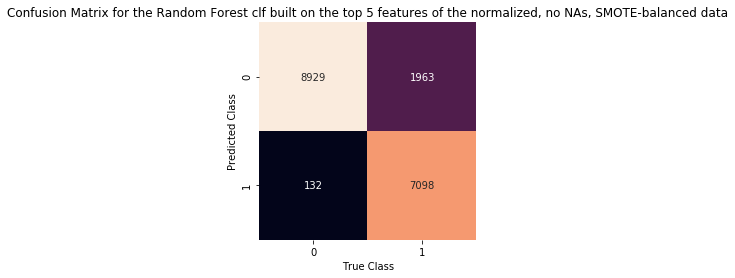

In [127]:
print("Total Classification Accuracy: {:0.4f} +/- {:0.4f})"
      .format(rf_top5_cv.mean(), rf_top5_cv.std()))
rf_top5_preds = rf_top5.predict(test10k_top5)
confusion_mat = metrics.confusion_matrix(test10k_labels_smote, rf_top5_preds)
confusion_mat_plotter(confusion_mat, [0,1], 
                      'for the Random Forest clf built on the top 5 features of' 
                      + ' the normalized, no NAs, SMOTE-balanced data')

## Analysis of random forest performance with SMOTE and feature selection
Not too bad, this classifier performed comparably to the 'SMOTE' random forest classifier. This did slightly better on specificity ($~0.985$ vs. $~0.978$), but didn't do quite as well regarding sensitivity ($~0.783$ vs $~0.813$). But it was much less time consuming to explore different parameters.

                                        Random Forest Table
|--- Training Results ---|--- Sensitivity/precision ---|---- Specificity/Recall ---|
| :--------------: | --------------------: | :---------------- |
| Raw Data | $\frac{0}{939+0} = 0$ | $\frac{9060}{9060+1} = 0.99989$ |
| Raw Data with Balanced Data | $\frac{7363}{7363+1698} = 0.81260$ | $\frac{8866}{8866+195} = 0.97848$ |
| Normalize Attributes | $\frac{8473}{8473+588} = 0.06489$ | $\frac{8840}{8840+221} = 0.97561$ |
| Feature Selection | $\frac{7098}{7098+1963}=0.78336$ | $\frac{8929}{8929+132}=0.98543$ |

In [123]:
# help(sns.countplot)
# help(pd.read_csv)
# help(pd.DataFrame.drop)
# help(SMOTE.fit_sample)
# help(StandardScaler)